# Multivariate LSTM-FCNs for predictive maintenance

[Reference](https://arxiv.org/pdf/1801.04503.pdf)

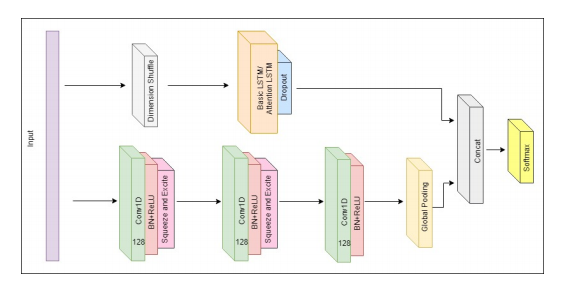

In [1]:
import numpy as np
import tensorflow as tf

## Model Building

### Fully convolutional branch

#### Sequeeze and Excite (SE)

[Reference](https://arxiv.org/abs/1709.01507)

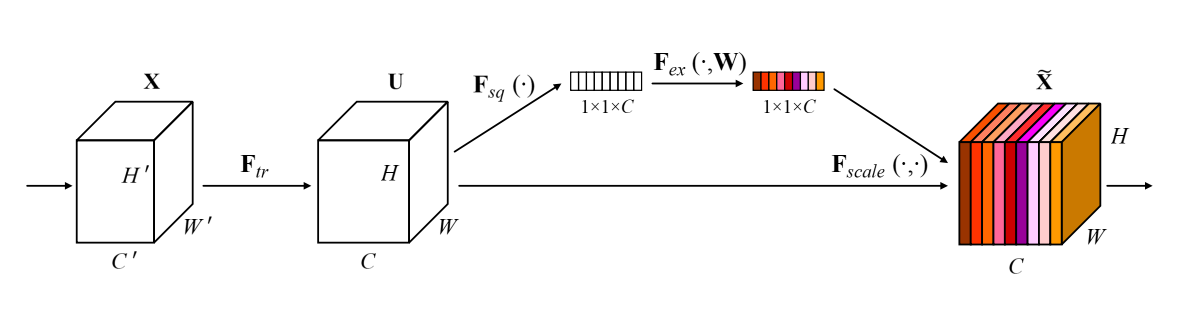

- Squeeze: The output of the transformation can be interpreted as a collection of the local descriptors whose statistics are expressive for the whole image
-  Excitation: The excitation operator maps the inputspecific descriptor z to a set of channel weights. In this regard, SE blocks intrinsically introduce dynamics conditioned on the input, which can be regarded as a selfattention function on channels whose relationships are not confined to the local receptive field the convolutional filters are responsive to.

In [2]:
class SqueezeExcite(tf.keras.Model):
    def __init__(self, feature_maps_channels, reduction_ratio=16):
        """
        Parameters
        ----------
        feature_maps_channels: int
        reduction_ratio: float
        """
        super(SqueezeExcite, self).__init__(name='squeeze_and_excite_block')
        
        # Squeeze operation
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        
        # Excitation block
        ## Adds non linear interaction
        self.dense_1 = tf.keras.layers.Dense(feature_maps_channels / reduction_ratio, 
                                             activation='relu')
        
        ## Non-mutually-exclusive relationship
        self.dense_2 = tf.keras.layers.Dense(feature_maps_channels, activation='sigmoid')
        
    def call(self, inp):
        x = self.avg_pool(inp)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        return tf.keras.layers.multiply([inp, x])

Test the SE block with random input feature maps

In [3]:
random_feature_maps = np.random.random((1, 16, 64))
SqueezeExcite(random_feature_maps.shape[-1])(random_feature_maps).shape

TensorShape([1, 16, 64])

#### Feature extraction block


In [4]:
class FeatureExtractor(tf.keras.Model):
    def __init__(self, filters, kernel_size, se_net=True, reduction_ratio=16):
        name = "conv_fearure_extractor"
        name += '_with_se' if se_net else ''
        super(FeatureExtractor, self).__init__(name="conv_fearure_extractor")
        
        if se_net:
            assert reduction_ratio, 'If you using a SE block you must set a reduction_ratio'
        self.se_net = se_net
        
        self.conv = tf.keras.layers.Conv1D(filters, kernel_size, kernel_initializer='he_normal')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        if se_net:
            self.se = SqueezeExcite(filters, reduction_ratio)
    
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        if self.se_net:
            x = self.se(x)
        return x

Now we can go back to the start and implement the Fully Convolutional Network (FCN) branch.

In [5]:
class FCN(tf.keras.Model):
    def __init__(self):
        super(FCN, self).__init__(name="fcn_branch")
        self.feature_extractor_1 = FeatureExtractor(128, 3)
        self.feature_extractor_2 = FeatureExtractor(256, 7)
        self.feature_extractor_3 = FeatureExtractor(128, 7, se_net=False)
        self.global_pooling = tf.keras.layers.GlobalMaxPool1D()
    
    def call(self, x):
        x = self.feature_extractor_1(x)
        x = self.feature_extractor_2(x)
        x = self.feature_extractor_3(x)
        return self.global_pooling(x)

### LSTM Branch

In [6]:
class Recurrent(tf.keras.Model):
    def __init__(self):
        super(Recurrent, self).__init__(name="lstm_branch")
        
        self.permute = tf.keras.layers.Permute((2, 1))
        self.lstm = tf.keras.layers.LSTM(128, return_sequences=False) # Grid Search from 8 to 128
        self.dropout = tf.keras.layers.Dropout(.8)
        
    def call(self, x):
        x = self.permute(x)
        x = self.lstm(x)
        return self.dropout(x)

### Join branches

In [7]:
class MLSTMFCN(tf.keras.Model):
    def __init__(self, n_classes):
        super(MLSTMFCN, self).__init__(name="multivariate_lstm_fcn")
        self.recurrent = Recurrent()
        self.fcn = FCN()
        if n_classes > 1:
            self.predictions = tf.keras.layers.Dense(n_classes, activation='softmax')
        else:
            self.predictions = tf.keras.layers.Dense(n_classes, activation='sigmoid')

    def call(self, x):
        out_1 = self.recurrent(x)
        out_2 = self.fcn(x)
        out = tf.keras.layers.concatenate([out_1, out_2])
        return self.predictions(out)

In [8]:
MLSTMFCN(5)(np.random.random((1, 50, 20)).astype('float32'))

W0606 13:04:52.703798 11480 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000001ED3A972400>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


<tf.Tensor: id=623, shape=(1, 5), dtype=float32, numpy=
array([[0.27035603, 0.23097351, 0.20173033, 0.11494325, 0.18199687]],
      dtype=float32)>

## Define training step

In [9]:
def schedule(epoch, max_epochs):
    init_lr = 1e-3
    end_lr = 1e-4
    epoch_process = epoch / max_epochs
    return (end_lr + init_lr) * epoch_process

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

def train_step(X, y, model, loss_fn):
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = loss_fn(y, predictions) 
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss

## Apply the model on HAR

In [11]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd

In [12]:
SEQUENCE_LENGTH = 20

### Load the data

In [24]:
data_path = Path('../data/raw/HAR')
X_train = pd.read_csv(data_path.joinpath('train/X_train.txt'), delim_whitespace=True, header=None).values
y_train = pd.read_csv(data_path.joinpath('train/y_train.txt'), delim_whitespace=True, header=None).values

X_test = pd.read_csv(data_path.joinpath('test/X_test.txt'), delim_whitespace=True, header=None).values
y_test = pd.read_csv(data_path.joinpath('test/y_test.txt'), delim_whitespace=True, header=None).values

labels_df = pd.read_csv(data_path.joinpath('activity_labels.txt'), delim_whitespace=True, header=None)
labels_df.columns = ['id', 'label']
labels_df['id'] -= 1

In [14]:
labels_df

,id,label
0,0,WALKING
1,1,WALKING_UPSTAIRS
2,2,WALKING_DOWNSTAIRS
3,3,SITTING
4,4,STANDING
5,5,LAYING


In [25]:
def gen_sequence(X, seq_length):
    num_elements = X.shape[0]
    
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        data = X[start:stop, :]
        yield data

### Generate sets of sequences

In [26]:
X_train = np.array(list(gen_sequence(X_train, SEQUENCE_LENGTH)))
y_train = y_train[SEQUENCE_LENGTH:]
y_train -= 1 # from 0 to 5

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

In [28]:
X_test = np.array(list(gen_sequence(X_test, SEQUENCE_LENGTH)))
y_test = y_test[SEQUENCE_LENGTH:]
y_test -= 1 # from 0 to 5

### Train the model

In [19]:
from keras.utils.generic_utils import Progbar

Using TensorFlow backend.


In [20]:
BATCH_SIZE = 128
EPOCHS = 100

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype('float32'), 
                                                    tf.keras.utils.to_categorical(y_train)))
train_dataset = train_dataset.batch(BATCH_SIZE).repeat(EPOCHS)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype('float32'), 
                                                  tf.keras.utils.to_categorical(y_val)))
val_dataset = val_dataset.batch(BATCH_SIZE // 4).repeat(-1)

In [44]:
tf.keras.utils.to_categorical(y_val).shape

(1467, 6)

In [30]:
steps_per_epoch = X_train.shape[0] // BATCH_SIZE

In [32]:
model = MLSTMFCN(labels_df.shape[0])
loss_fn = tf.keras.losses.CategoricalCrossentropy()

for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = Progbar(steps_per_epoch)
    
    optimizer.lr = schedule(epoch, EPOCHS)
    
    for step, (X, y) in enumerate(train_dataset):

        train_loss = train_step(X, y, model, loss_fn)

        # Compute accuracy
        preds = model(X)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.argmax(y, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        progbar.add(1, values=[('training loss', train_loss), ('train acc.', accuracy)])
        
        if step >= steps_per_epoch:
            break
            
    # Validation step
    y_trues = []
    y_preds = []
    for i, (X, y) in enumerate(val_dataset):
        print(X.shape)
        preds = model(X)
        y_trues.extend(np.argmax(y, axis=1))
        y_preds.extend(np.argmax(preds, axis=1))
        if i >= 20:
            break

    print(classification_report(y_trues, y_preds))
    

W0606 13:06:55.613335 11480 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000001EE339212E8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 0/100
46/45 [==============================] - 9s 204ms/step - training loss: 1.7886 - train acc.: 0.1810
(32, 128, 20, 561)


InvalidArgumentError: transpose expects a vector of size 4. But input(1) is a vector of size 3 [Op:Transpose] name: multivariate_lstm_fcn/lstm_branch/permute_3/transpose/